In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#plt.rcParams()

# Dataset 

In [4]:
data_path = "../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
N_ELECTRONS = 16
basis = "6-311++g**"
subfolder = "EmbeddedBlocks/"

#data_path = "../../../cc2ai/ethen/"
#postfix = "_ethen_6-31g**"
#dim = 48
#N_ELECTRONS = 16
#basis = "6-31g**"

#data_path = "../thesis/dataset/TSmall_sto3g"
#postfix = "TSmall_sto3g"
#dim = 26
#N_ELECTRONS = 30
#basis = "sto-3g"

#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26

In [5]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split
from pyscf.scf import hf


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#S, P = np.load(join(data_path, "dataset" + postfix + ".npy"))
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

#index = np.load(join(data_path, "index" + postfix + ".npy"))


#ind = int(0.8 * len(S))
ind = 0


molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])



h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)
#s_test, p_test = S.reshape(-1, dim, dim), P.reshape(-1, dim, dim)

In [7]:
def fock_from_density_batch(p_batch):
    f = []
    for p, s, h, mol in zip(p_batch, s_test, h_test, molecules[1]):
        f.append(hf.get_fock(None, h1e=h, s1e=s, vhf=hf.get_veff(mol=mol.get_pyscf_molecule(), dm=p), dm=p))
    return np.array(f)

f_test = fock_from_density_batch(p_test)

# Calculate guesses 

In [8]:
from SCFInitialGuess.construction.fock import gwh_scheme

def gwh_scheme_wrapper(M, k=1.75):
    F = []
    for m, s in zip(M, s_test):
        F.append(gwh_scheme(np.diag(m), s, k))
        
    return np.array(F)

In [9]:
f_gwh = gwh_scheme_wrapper(h_test)

In [10]:
f_nn_gwh = gwh_scheme_wrapper(f_test)

# Calculate Error 

In [11]:
e_gwh = np.mean(np.abs(f_gwh - f_test), 0)

In [12]:
e_nn_gwh = np.mean(np.abs(f_nn_gwh - f_test), 0)

# Plot 

In [13]:
plt.rcParams['figure.figsize'] = (8, 4)

In [18]:
export_folder = "/home/jcartus/Repos/MastersThesis/Construction/figures/"

In [15]:
vmin = 0
vmax = 3

ylabel = r"Row Index / 1"
xlabel = r"Column Index / 1"

norm = plt.Normalize(vmin, vmax)

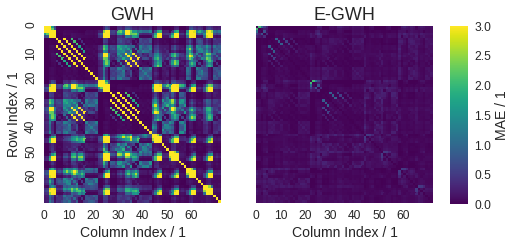

In [35]:
fig, axes = plt.subplots(1, 2)#, sharex=True, sharey=True)
#title_size = 20
#label_size = 15
ticks = np.arange(0,70, 10)

cbar_ax = fig.add_axes([.83, .19, .03, .62])

sns.heatmap(
    e_gwh, 
    square=True, 
    ax=axes[0], 
    cbar=True, 
    cbar_ax=cbar_ax, 
    cbar_kws={'label': 'MAE / 1'}, 
    cmap="viridis",
    vmin=vmin, 
    vmax=vmax
)
axes[0].set_title("GWH")#, fontsize=title_size)
axes[0].set_xlabel(xlabel)#, fontsize=title_size)
axes[0].set_ylabel(ylabel)#, fontsize=title_size)
axes[0].set_yticks(ticks)
axes[0].set_xticks(ticks)
axes[0].set_yticklabels(ticks)
axes[0].set_xticklabels(ticks)
#axes[0].tick_params(labelsize=label_size)
#plt.yticks(ticks, ticks)


sns.heatmap(
    e_nn_gwh, 
    square=True, 
    ax=axes[1], 
    cbar=False, 
    cmap="viridis",
    vmin=vmin, 
    vmax=vmax
)
axes[1].set_title("E-GWH")#, fontsize=title_size)
#axes[1].ticklabel_format(style='plain', axis='y')
axes[1].set_xlabel(xlabel)#, fontsize=title_size)
#axes[1].tick_params(labelsize=label_size)
axes[1].set_yticks(ticks)
axes[1].set_xticks(ticks)
axes[1].set_yticklabels(ticks)
axes[1].set_xticklabels(ticks)



_ = plt.setp([a.get_yticklabels() for a in [axes[1]]], visible=False)

fig.subplots_adjust(right=0.8)

#cbar_ax.tick_params(labelsize=label_size)
#cbar_ax.set_ylabel('MAE / 1', fontsize=20)

#plt.rcParams["axes.edgecolor"] = "0.15"
#plt.rcParams["axes.linewidth"] = 1.25
#


plt.savefig(export_folder + "EGWH_MatrixError.pdf")


In [31]:
ticks

array([ 0, 10, 20, 30, 40, 50, 60])